<a href="https://colab.research.google.com/github/mbedjoko/-DevoirDeveloppementWeb/blob/main/cell_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

mekemebedjoko_cell_images_path = kagglehub.dataset_download('mekemebedjoko/cell-images')
mekemebedjoko_mobilenet_v2_weight_path = kagglehub.dataset_download('mekemebedjoko/mobilenet-v2-weight')

print('Data source import complete.')


Load & Explore Data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np # linear algebra
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import cv2
from pathlib import Path


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

base_dir = "/kaggle/input/cell-images"

parasite_images = os.listdir(os.path.join(base_dir, "/kaggle/input/cell-images/cell_images/cell_images/Parasitized"))
uninfected_images = os.listdir(os.path.join(base_dir, "/kaggle/input/cell-images/cell_images/cell_images/Uninfected"))

print("Parasite:", len(parasite_images))
print("Uninfected:", len(uninfected_images))

/kaggle/input/mobilenet-v2-weight/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
/kaggle/input/cell-images/cell_images/dataset-metadata.json
/kaggle/input/cell-images/cell_images/cell_images/Uninfected/C203ThinF_IMG_20151029_102123_cell_51.png
/kaggle/input/cell-images/cell_images/cell_images/Uninfected/C238NThinF_IMG_20151207_114038_cell_84.png
/kaggle/input/cell-images/cell_images/cell_images/Uninfected/C119P80ThinF_IMG_20151002_124304_cell_112.png
/kaggle/input/cell-images/cell_images/cell_images/Uninfected/C39P4thinF_original_IMG_20150622_111723_cell_33.png
/kaggle/input/cell-images/cell_images/cell_images/Uninfected/C101P62ThinF_IMG_20150918_151149_cell_63.png
/kaggle/input/cell-images/cell_images/cell_images/Uninfected/C180P141NThinF_IMG_20151201_165601_cell_115.png
/kaggle/input/cell-images/cell_images/cell_images/Uninfected/C95P56ThinF_IMG_20150821_171603_cell_75.png
/kaggle/input/cell-images/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102516_ce

* Check the number of images
* Check the balance of the class
* Check the size of images

Data Preparation

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.30,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = val_test_ds.take(int(len(val_test_ds) * 0.5))
test_ds = val_test_ds.skip(int(len(val_test_ds) * 0.5))

Found 27558 files belonging to 1 classes.
Using 19291 files for training.
Found 27558 files belonging to 1 classes.
Using 8267 files for validation.


Build Model – MobileNetV2

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze base

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

Train Model

In [ ]:
EPOCHS = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/15


I0000 00:00:1769245036.805342     138 service.cc:152] XLA service 0x78b1881116a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769245036.805402     138 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769245038.003457     138 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1769245044.460478     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


603/603 ━━━━━━━━━━━━━━━━━━━━ 68s 90ms/step - accuracy: 0.9901 - loss: 0.0297 - val_accuracy: 1.0000 - val_loss: 5.6702e-06
Epoch 2/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 1.0000 - loss: 3.3996e-05 - val_accuracy: 1.0000 - val_loss: 1.2741e-06
Epoch 3/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 1.0000 - loss: 2.2161e-05 - val_accuracy: 1.0000 - val_loss: 4.7591e-07
Epoch 4/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 1.0000 - loss: 1.2201e-05 - val_accuracy: 1.0000 - val_loss: 2.1179e-07
Epoch 5/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 1.0000 - loss: 5.4270e-06 - val_accuracy: 1.0000 - val_loss: 1.1813e-07
Epoch 6/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 1.0000 - loss: 5.5110e-06 - val_accuracy: 1.0000 - val_loss: 6.4578e-08
Epoch 7/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 1.0000 - loss: 4.6132e-06 - val_accuracy: 1.0000 - val_loss: 3.8684e-08
Epoch 8/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/

Training Results Visualization

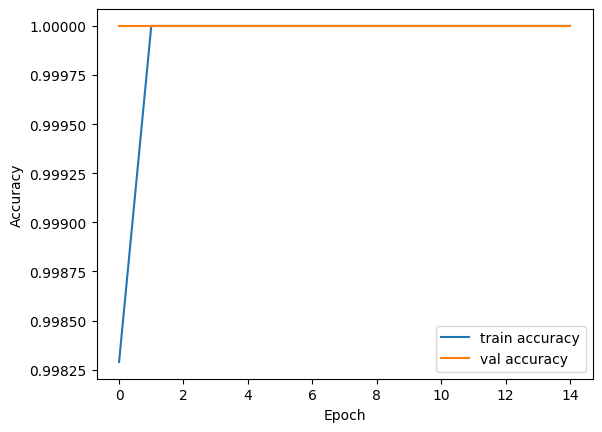

In [ ]:
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Evaluate on Test Set

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


130/130 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 1.0000 - loss: 3.7595e-10
Test Accuracy: 1.0


In [ ]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = (model.predict(test_ds) > 0.5).astype(int)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step
[[4139]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4139

    accuracy                           1.00      4139
   macro avg       1.00      1.00      1.00      4139
weighted avg       1.00      1.00      1.00      4139



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Predictions on New Images

In [ ]:

img = image.load_img("/kaggle/input/cell-images/cell_images/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_170.png", target_size=IMG_SIZE)
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
print("Parasitized" if prediction > 0.5 else "Uninfected")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Uninfected


In [ ]:
# Dataset paths (auto-detects Kaggle or local)
import os

# Check if running on Kaggle
if os.path.exists('/kaggle'):
    possible_paths = [
        Path('/kaggle/input/cell-images/cell_images'),
    ]
    base_dir = None
    for path in possible_paths:
        if path.exists():
            base_dir = path
            break

    if base_dir is None:
        # List available folders in /kaggle/input/
        input_dir = Path('/kaggle/input')
        if input_dir.exists():
            print("Available folders in /kaggle/input/:")
            for item in input_dir.iterdir():
                print(f"  - {item}")
        raise FileNotFoundError("Dataset not found. Check your Kaggle dataset name.")
else:
    # Local development
    base_dir = Path('.')

parasitized_dir = base_dir / '/kaggle/input/cell-images/cell_images/cell_images/Parasitized'
uninfected_dir = base_dir / '/kaggle/input/cell-images/cell_images/cell_images/Uninfected'

# Verify paths
print(f"Parasitized folder exists: {parasitized_dir.exists()}")
print(f"Uninfected folder exists: {uninfected_dir.exists()}")

# Count images
parasitized_count = len(list(parasitized_dir.glob('*.png')))
uninfected_count = len(list(uninfected_dir.glob('*.png')))

print(f"\nParasitized images: {parasitized_count}")
print(f"Uninfected images: {uninfected_count}")
print(f"Total images: {parasitized_count + uninfected_count}")

Parasitized folder exists: True
Uninfected folder exists: True

Parasitized images: 13779
Uninfected images: 13779
Total images: 27558


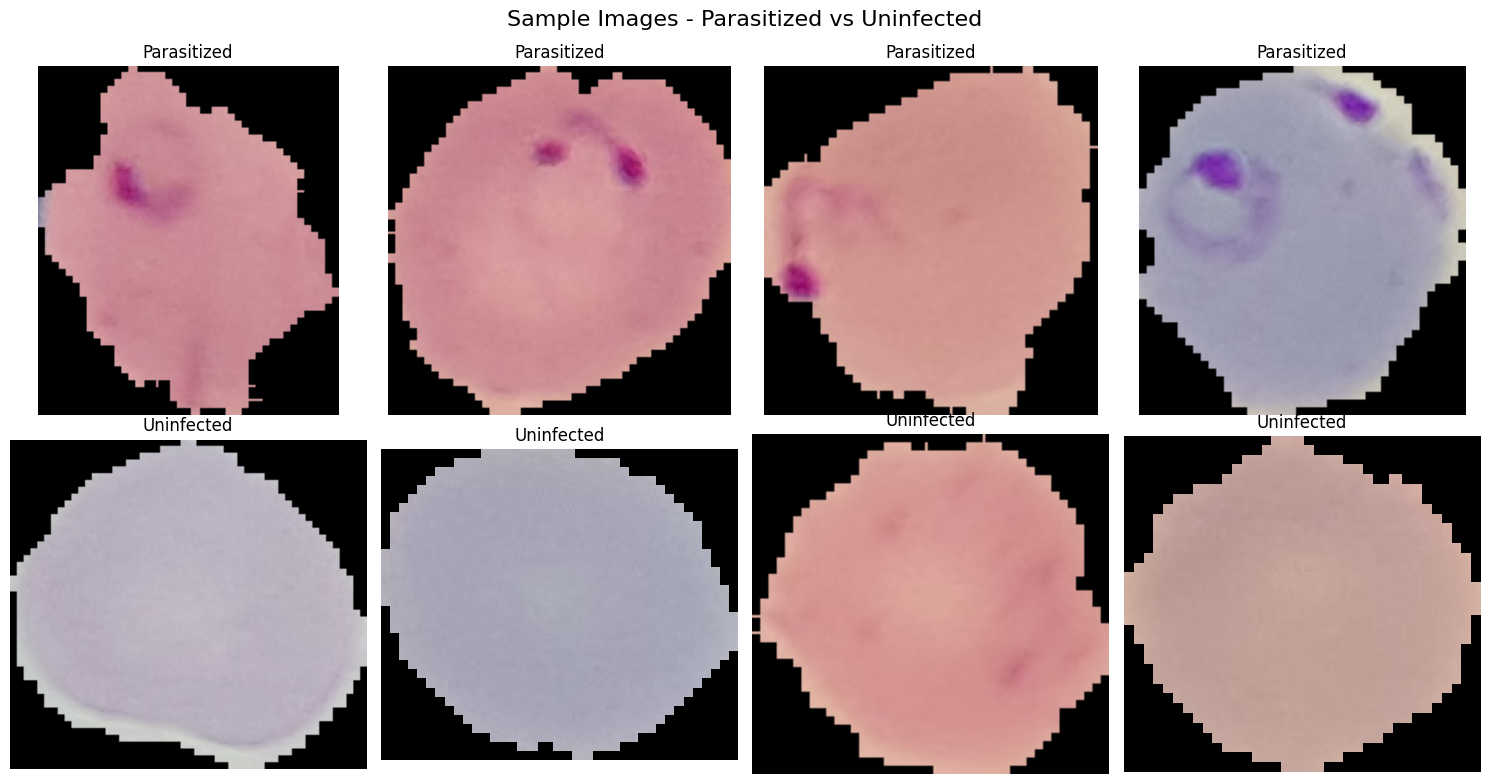

In [ ]:
# Visualize sample images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Sample Images - Parasitized vs Uninfected', fontsize=16)

# Parasitized images
parasitized_files = list(parasitized_dir.glob('*.png'))[:4]
for idx, img_path in enumerate(parasitized_files):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, idx].imshow(img)
    axes[0, idx].set_title('Parasitized')
    axes[0, idx].axis('off')

# Uninfected images
uninfected_files = list(uninfected_dir.glob('*.png'))[:4]
for idx, img_path in enumerate(uninfected_files):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, idx].imshow(img)
    axes[1, idx].set_title('Uninfected')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Parameters
IMG_SIZE = 224  # Standard size for pre-trained models
BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 0.0001

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    classes=['Parasitized', 'Uninfected']
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    classes=['Parasitized', 'Uninfected']
)

print(f"Classes: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Classes: {'Parasitized': 0, 'Uninfected': 1}
Training samples: 0
Validation samples: 0


In [ ]:
model.save("parasite_classifier_mobilenetv2.keras")
